In [22]:
import pandas as pd
import os

data_dir = os.path.join(os.path.dirname(os.getcwd()), "demo", "data")

demo_train = pd.read_csv(os.path.join(data_dir, "demo_train.csv"))
demo_test = pd.read_csv(os.path.join(data_dir, "demo_test.csv"))
demo_val = pd.read_csv(os.path.join(data_dir, "demo_val.csv"))

print(len(demo_train))
print(len(demo_test))
print(len(demo_val))

2000
400
200


In [23]:
demo_train.head()

,email_text,type,label,word_lengths,word_count
0,bryan roycroft wrote:\n> has anyone got inform...,Safe Email,0,"[5, 8, 6, 1, 3, 6, 3, 11, 2, 8, 3, 7, 2, 1, 3,...",94
1,\nThe Internet's Online PharmacyViagra - Xenic...,Phishing Email,1,"[3, 10, 6, 14, 1, 7, 1, 8, 1, 8, 1, 7, 1, 6, 1...",73
2,"hello , ssuper medz hello , welcome to pharmon...",Phishing Email,1,"[5, 1, 6, 4, 5, 1, 7, 2, 9, 9, 2, 8, 4, 1, 3, ...",79
3,">>>>> ""b"" == bitbitch writes: b> .. I wou...",Safe Email,0,"[5, 3, 2, 8, 7, 2, 2, 1, 8, 9, 3, 4, 12, 5, 2,...",397
4,"moore medz hello , welcome to medzonline sho a...",Phishing Email,1,"[5, 4, 5, 1, 7, 2, 10, 3, 10, 1, 2, 3, 7, 2, 9...",83


In [24]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def plot_and_log_confusion_matrix(y_true, y_pred, title, filename, figsize=(10,8)):
    """
    Confusion matrix oluşturur ve görselleştirir
    """
    # Confusion matrix hesapla
    cm = confusion_matrix(y_true, y_pred)
    
    tn, fp, fn, tp = cm.ravel()
    
    plt.figure(figsize=figsize)
    
    sns.heatmap(cm, 
                annot=True,
                fmt='d',
                cmap='Blues',
                xticklabels=['Güvenli', 'Oltalama'],
                yticklabels=['Güvenli', 'Oltalama'])
    
    plt.title(title)
    plt.xlabel('Tahmin Edilen')
    plt.ylabel('Gerçek')
    
    # Grafiği kaydet
    plt.savefig(filename)
    
    plt.show()
    
    # Metrikleri yazdır
    print(f"\n{title}")
    print(f"True Negatives (Güvenli doğru tahmin): {tn}")
    print(f"False Positives (Güvenli yanlış tahmin): {fp}")
    print(f"False Negatives (Oltalama yanlış tahmin): {fn}")
    print(f"True Positives (Oltalama doğru tahmin): {tp}")
    
    return {
        "true_negatives": tn,
        "false_positives": fp,
        "false_negatives": fn,
        "true_positives": tp
    }

In [25]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import os

def train_and_evaluate_svm(train_data, val_data, test_data, dataset_name,
                          out_dir, text_column='email_text'):
    """
    En iyi parametrelerle SVM modeli eğitilir ve değerlendirilir.
    """
    # En iyi parametreler
    best_params = {
        'tfidf__max_features': 5000,
        'tfidf__ngram_range': (1, 2),
        'svm__kernel': 'rbf',
        'svm__class_weight': 'balanced',
        'svm__gamma': 'scale'
    }
    
    # Pipeline oluştur
    pipeline = Pipeline([
        ('tfidf', TfidfVectorizer(
            max_features=best_params['tfidf__max_features'],
            ngram_range=best_params['tfidf__ngram_range']
        )),
        ('svm', SVC(
            kernel=best_params['svm__kernel'],
            class_weight=best_params['svm__class_weight'],
            gamma=best_params['svm__gamma']
        ))
    ])
    
    # Modeli eğit
    pipeline.fit(train_data[text_column], train_data['label'])
    
    # Tahminleri yap
    val_pred = pipeline.predict(val_data[text_column])
    test_pred = pipeline.predict(test_data[text_column])
    
    # Metrikleri hesapla
    val_metrics = {
        'val_accuracy': accuracy_score(val_data['label'], val_pred),
        'val_precision': precision_score(val_data['label'], val_pred),
        'val_recall': recall_score(val_data['label'], val_pred),
        'val_f1': f1_score(val_data['label'], val_pred)
    }
    
    test_metrics = {
        'test_accuracy': accuracy_score(test_data['label'], test_pred),
        'test_precision': precision_score(test_data['label'], test_pred),
        'test_recall': recall_score(test_data['label'], test_pred),
        'test_f1': f1_score(test_data['label'], test_pred)
    }
    
    os.makedirs(out_dir, exist_ok=True)
    model_path = os.path.join(out_dir, f"{dataset_name}_model.pkl")
    vectorizer_path = os.path.join(out_dir, f"{dataset_name}_vectorizer.pkl")
    
    full_pipeline_path = os.path.join(out_dir, f"{dataset_name}_full_pipeline.pkl")
    
    with open(model_path, 'wb') as f:
        pickle.dump(pipeline['svm'], f)
    
    with open(vectorizer_path, 'wb') as f:
        pickle.dump(pipeline['tfidf'], f)
    
    # Tüm pipeline'ı kaydet
    with open(full_pipeline_path, 'wb') as f:
        pickle.dump(pipeline, f)
    
    print(f"\nModeller kaydedildi:")
  
    # Confusion matrix'leri görselleştir ve kaydet
    plot_and_log_confusion_matrix(
        val_data['label'],
        val_pred,
        'Validation Seti Confusion Matrix',
        os.path.join(out_dir, f"validation_confusion_matrix_{dataset_name}.png")
    )
    
    plot_and_log_confusion_matrix(
        test_data['label'],
        test_pred,
        'Test Seti Confusion Matrix',
        os.path.join(out_dir, f"test_confusion_matrix_{dataset_name}.png")
    )
    
    # Sonuçları yazdır
    print(f"\nValidation metrikleri:")
    for metric, value in val_metrics.items():
        print(f"{metric}: {value:.4f}")
        
    print(f"\nTest metrikleri:")
    for metric, value in test_metrics.items():
        print(f"{metric}: {value:.4f}")
    
    return pipeline, val_pred, test_pred


Modeller kaydedildi:


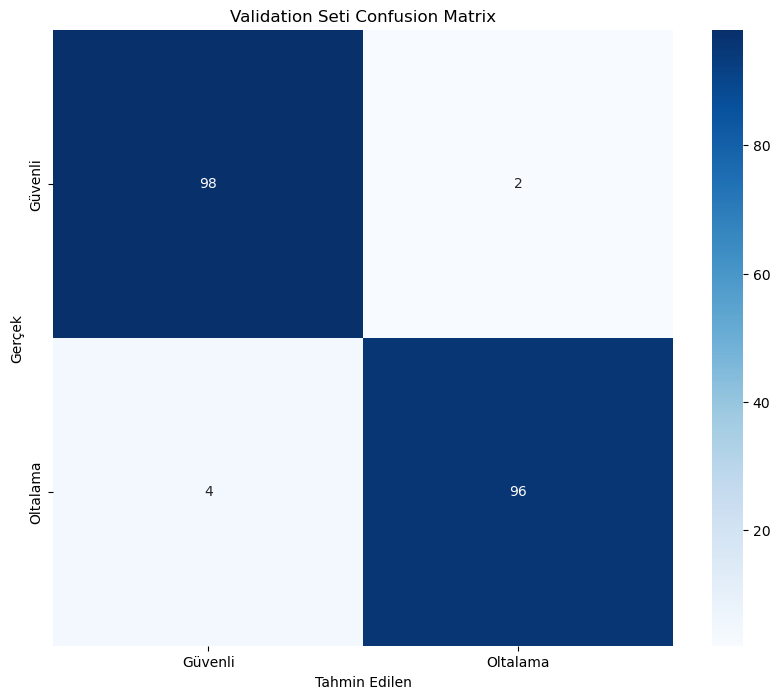


Validation Seti Confusion Matrix
True Negatives (Güvenli doğru tahmin): 98
False Positives (Güvenli yanlış tahmin): 2
False Negatives (Oltalama yanlış tahmin): 4
True Positives (Oltalama doğru tahmin): 96


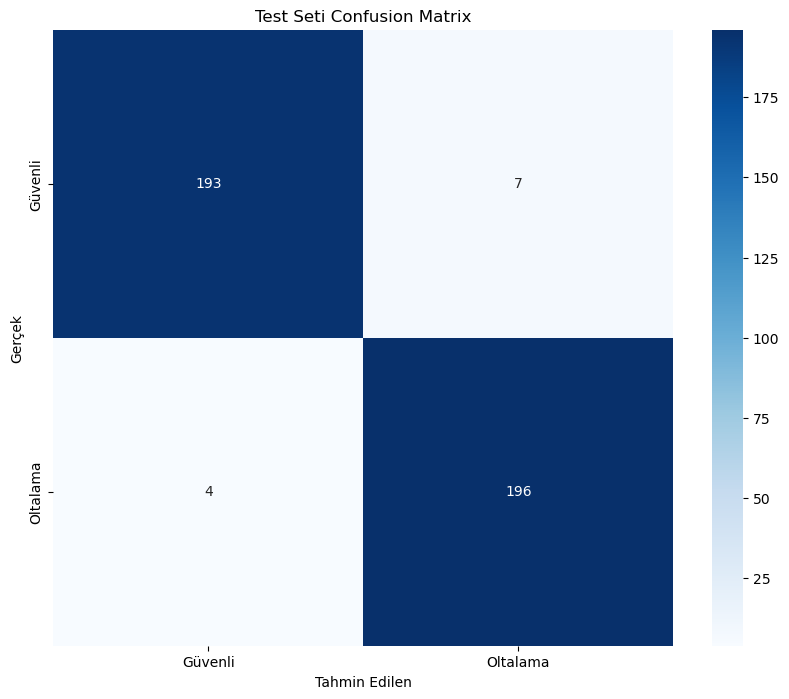


Test Seti Confusion Matrix
True Negatives (Güvenli doğru tahmin): 193
False Positives (Güvenli yanlış tahmin): 7
False Negatives (Oltalama yanlış tahmin): 4
True Positives (Oltalama doğru tahmin): 196

Validation metrikleri:
val_accuracy: 0.9700
val_precision: 0.9796
val_recall: 0.9600
val_f1: 0.9697

Test metrikleri:
test_accuracy: 0.9725
test_precision: 0.9655
test_recall: 0.9800
test_f1: 0.9727
Training time: 3.23 seconds


In [26]:
import time
start_time = time.time()
model, val_pred, test_pred = train_and_evaluate_svm(
    train_data=demo_train,
    val_data=demo_val,
    test_data=demo_test,
    dataset_name="demo_svm",
    out_dir=os.path.join(os.path.dirname(os.getcwd()), "source", "models", "svm","demo"),
    text_column='email_text'
)
end_time = time.time()
print(f"Training time: {end_time - start_time:.2f} seconds")

## Gerçek Veri Seti ile Model Testi

Aşağıda oluşturulan modeli gerçek veri seti ile test edebiliriz.

In [27]:
import pandas as pd

df_test = pd.read_excel(os.path.join(os.path.dirname(os.getcwd()), "source", "real-test-set.xlsx"))
df_test.head()

,text,label
0,"Hello John,\n\nIt was a pleasure meeting you a...",0
1,"Hi Team,\n\nJust a quick reminder about our ma...",0
2,"Dear Sarah,\n\nWelcome to the Customer Support...",0
3,"Hello Clara,\n\nThank you for your recent purc...",0
4,"Dear Team,\n\nGiven our recent discussion on m...",0


In [28]:
def load_model(model_path, vectorizer_path=None):
    """
    Kaydedilmiş modeli yükler
    """
    if model_path.endswith('pkl'):
        if vectorizer_path:
            with open(model_path, 'rb') as f:
                model = pickle.load(f)
            with open(vectorizer_path, 'rb') as f:
                vectorizer = pickle.load(f)
            return model, vectorizer
        else:
            with open(model_path, 'rb') as f:
                pipeline = pickle.load(f)
            return pipeline
    else:
        raise ValueError("Desteklenmeyen dosya formatı")

In [30]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import pickle
import os

def evaluate_model_with_real_data(model_path, vectorizer_path, test_df, 
                                  text_column='text', label_column='label'):
    """
    Kaydedilmiş modelin gerçek verilerle test edilmesi
    """
    with open(model_path, 'rb') as f:
        model = pickle.load(f)
    with open(vectorizer_path, 'rb') as f:
        vectorizer = pickle.load(f)
    
    # Metinleri vektörleştirir
    X_test = vectorizer.transform(test_df[text_column])
    
    y_pred = model.predict(X_test)
    
    metrics = {
        'accuracy': accuracy_score(test_df[label_column], y_pred),
        'precision': precision_score(test_df[label_column], y_pred),
        'recall': recall_score(test_df[label_column], y_pred),
        'f1': f1_score(test_df[label_column], y_pred)
    }
    
    cm_metrics = plot_and_log_confusion_matrix(
        test_df[label_column],
        y_pred,
        'Test Seti Confusion Matrix',
        'confusion_matrix_test.png'
    )
    
    print("Model Performansı:")
    for metric_name, value in metrics.items():
        print(f"{metric_name}: {value:.4f}")


    results_df = test_df.copy()
    results_df['predicted_label'] = y_pred
    results_df['correct_prediction'] = results_df[label_column] == results_df['predicted_label']
    
    wrong_predictions = results_df[~results_df['correct_prediction']]
    print(f"\nYanlış tahmin edilen örnek sayısı: {len(wrong_predictions)}")
    
    if len(wrong_predictions) > 0:
        print("\nYanlış tahmin edilen örnekler:")
        for idx, row in wrong_predictions.iterrows():
            print(f"\nÖrnek {idx}:")
            print(f"Gerçek etiket: {row[label_column]}")
            print(f"Tahmin edilen: {row['predicted_label']}")
            print(f"Metin: {row[text_column][:200]}...")  # İlk 200 karakter
    
    return metrics, cm_metrics, results_df


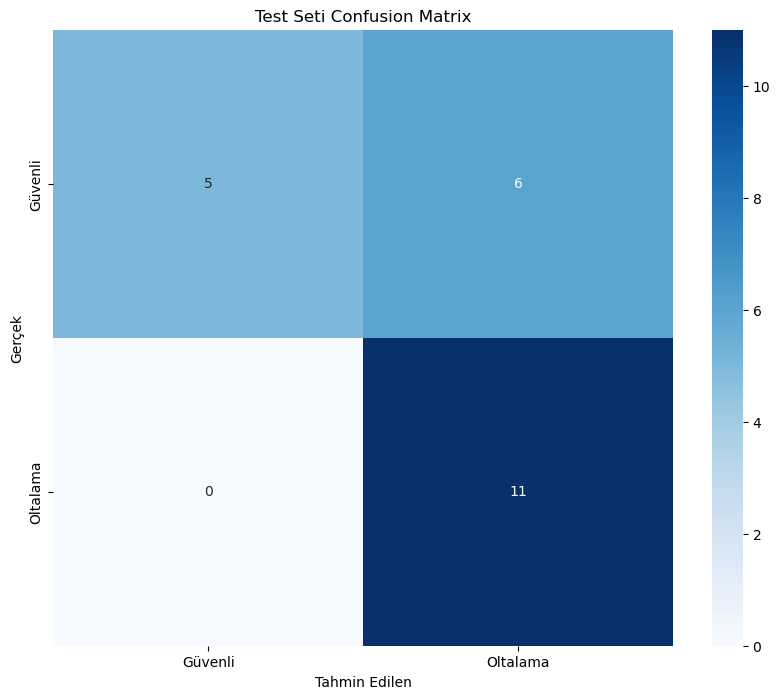


Test Seti Confusion Matrix
True Negatives (Güvenli doğru tahmin): 5
False Positives (Güvenli yanlış tahmin): 6
False Negatives (Oltalama yanlış tahmin): 0
True Positives (Oltalama doğru tahmin): 11
Model Performansı:
accuracy: 0.7273
precision: 0.6471
recall: 1.0000
f1: 0.7857

Yanlış tahmin edilen örnek sayısı: 6

Yanlış tahmin edilen örnekler:

Örnek 0:
Gerçek etiket: 0
Tahmin edilen: 1
Metin: Hello John,

It was a pleasure meeting you at the Annual Business Conference last week. I really enjoyed our conversation about the innovative ways technology is transforming industry workflows, espec...

Örnek 2:
Gerçek etiket: 0
Tahmin edilen: 1
Metin: Dear Sarah,

Welcome to the Customer Support team at Widget Corp! We are thrilled to have you on board and look forward to seeing the contributions you will make.

Your first week will be primarily or...

Örnek 3:
Gerçek etiket: 0
Tahmin edilen: 1
Metin: Hello Clara,

Thank you for your recent purchase of the Deluxe Coffee Maker from our store

In [31]:
model_root = os.path.join(os.path.dirname(os.getcwd()), "source", "models", "svm", "demo")
model_path = os.path.join(model_root, "demo_svm_model.pkl")
vectorizer_path = os.path.join(model_root, "demo_svm_vectorizer.pkl")

metrics, confusion_matrix, results = evaluate_model_with_real_data(
    model_path=model_path,
    vectorizer_path=vectorizer_path,
    test_df=df_test,
    text_column='text',  # Excel'deki metin kolonu adı
    label_column='label'  # Excel'deki etiket kolonu adı
)
